<a href="https://colab.research.google.com/github/duonghiepit/traffic-sign-detection/blob/main/TrafficSignDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
# https://drive.google.com/file/d/1YJiHQeLotsaXAXCtLLKBHPaawqKiSC5b/view?usp=drive_link
!gdown --id 1YJiHQeLotsaXAXCtLLKBHPaawqKiSC5b

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1YJiHQeLotsaXAXCtLLKBHPaawqKiSC5b
To: /content/drive/My Drive/traffic_sign_detection/traffic_sign_detection.zip
100% 229M/229M [00:04<00:00, 50.3MB/s]


In [ ]:
!unzip traffic_sign_detection.zip

# Import libraries

In [ ]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from google.colab.patches import cv2_imshow


from skimage import feature
from sklearn.svm import SVC
from skimage.transform import resize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# **I. Build Traffic Sign Classification Model (SVM)**

## 1. Read and extract dataset

In [ ]:
annotations_dir = 'annotations'
img_dir = 'images'

img_lst = []
label_lst = []
#count=0
for xml_file in os.listdir(annotations_dir):
    xml_filepath = os.path.join(annotations_dir, xml_file)
    tree = ET.parse(xml_filepath)
    root = tree.getroot()

    folder = root.find('folder').text
    img_filename = root.find('filename').text
    img_filepath = os.path.join(img_dir, img_filename)
    img = cv2.imread(img_filepath)
    #cv2_imshow(img)

    for obj in root.findall('object'):
        classname = obj.find('name').text
        if classname == 'trafficlight':
            continue

        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)
        #print((xmin, ymin, xmax, ymax))

        object_img = img[ymin:ymax, xmin:xmax]
        img_lst.append(object_img)
        label_lst.append(classname)
        #cv2_imshow(object_img)

    #count += 1
    #
    #if count == 5:
    #    break

In [ ]:
print('Number of objects:', len(img_lst))
print('Class name:', list(set(label_lst)))

Number of objects: 1074
Class name: ['stop', 'speedlimit', 'crosswalk']


## 2. Preprocess images

In [ ]:
def preprocessing_img(img):
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype(np.float32)

    resized_img = resize(
        img,
        output_shape=(32, 32),
        anti_aliasing=True
    )

    hog_feature = feature.hog(
        resized_img,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        transform_sqrt=True,
        block_norm="L2",
        feature_vector=True
    )

    return hog_feature

In [ ]:
img_features_lst = []
for img in img_lst:
    hog_feature = preprocessing_img(img)
    img_features_lst.append(hog_feature)

img_features = np.array(img_features_lst)

In [ ]:
print('X shape:')
print(img_features.shape)

X shape:
(1074, 324)


## 3. Encode label

In [ ]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(label_lst)

In [ ]:
label_encoder.classes_

array(['crosswalk', 'speedlimit', 'stop'], dtype='<U10')

In [ ]:
encoded_labels[:100]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1])

## 4. Split train val set

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(img_features,
                                                  encoded_labels,
                                                  test_size = 0.3,
                                                  random_state= 0,
                                                  shuffle=True)

## 5. Normalization

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

## 6. Training

In [ ]:
clf = SVC(
    kernel = 'rbf',
    random_state=0,
    probability=True,
    C=0.5
)

clf.fit(X_train, y_train)

SVC(C=0.5, probability=True, random_state=0)

## 7. Evaluation

In [ ]:
y_pred = clf.predict(X_val)
score = accuracy_score(y_pred, y_val)

print('Evaluation results on val set')
print('Accuracy: ', score)

Evaluation results on val set
Accuracy:  0.9845201238390093


In [ ]:
input_img = img_lst[1]
normalized_img = preprocessing_img(input_img)
y_pred = clf.predict([normalized_img])[0]
print(f'Normal prediction: {y_pred}')

Normal prediction: 1


In [ ]:
y_pred_prob = clf.predict_proba([normalized_img])
prediction = np.argmax(y_pred_prob)
y_pred_prob = [f'{p:.10f}' for p in y_pred_prob[0]]
print(f'Probability of each class: {y_pred_prob}')
print(f'Class with highest probability: {prediction}')

Probability of each class: ['0.0000000011', '0.9999638963', '0.0000361026']
Class with highest probability: 1


# II. Traffic Sign Localization (Sliding Window)

## 1. Create sliding window function

In [ ]:
def sliding_window(img, window_sizes, stride, scale_factor):
    img_height, img_width = img.shape[:2]
    windows = []
    for window_size in window_sizes:
        window_width, window_height = window_size
        for ymin in range(0, img_height - window_height + 1, stride):
            for xmin in range(0, img_width - window_width + 1, stride):
                xmax = xmin + window_width
                ymax = ymin + window_height

                windows.append([xmin, ymin, xmax, ymax])

    return windows

## 2. Create pyramid image function

In [ ]:
def pyramid(img, scale=0.8, min_size=(30, 30)):
    acc_scale = 1.0
    pyramid_imgs = [(img, acc_scale)]

    i = 0
    while True:
        acc_scale = acc_scale * scale

        h = int(img.shape[0] * acc_scale)
        w = int(img.shape[1] * acc_scale)
        if h < min_size[1] or w < min_size[0]:
            break
        img = cv2.resize(img, (w, h))
        pyramid_imgs.append((img, acc_scale * (scale ** i)))
        i += 1

    return pyramid_imgs

## 3. Create bounding box visualization function

In [ ]:
def visualize_bbox(img, bboxes, label_encoder):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for box in bboxes:
        xmin, ymin, xmax, ymax, predict_id, conf_score = box

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        classname = label_encoder.inverse_transform([predict_id])[0]
        label = f"{classname} {conf_score:.2f}"

        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)

        cv2.rectangle(img, (xmin, ymin - 20), (xmin + w, ymin), (0, 255, 0), -1)

        cv2.putText(img, label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

## 4. Create IoU computing function

In [ ]:
def compute_iou(bbox, bboxes, bbox_area, bboxes_area):
    xxmin = np.maximum(bbox[0], bboxes[:, 0])
    yymin = np.maximum(bbox[1], bboxes[:, 1])
    xxmax = np.minimum(bbox[2], bboxes[:, 2])
    yymax = np.minimum(bbox[3], bboxes[:, 3])

    w = np.maximum(0, xxmax - xxmin + 1)
    h = np.maximum(0, yymax - yymin + 1)

    intersection = w * h
    iou = intersection / (bbox_area + bboxes_area - intersection)

    return iou

## 5. Create Non-Maximum Suppression function

In [ ]:
def nms(bboxes, iou_threshold):
    if not bboxes:
        return []

    scores = np.array([bbox[5] for bbox in bboxes])
    sorted_indices = np.argsort(scores)[::-1]

    xmin = np.array([bbox[0] for bbox in bboxes])
    ymin = np.array([bbox[1] for bbox in bboxes])
    xmax = np.array([bbox[2] for bbox in bboxes])
    ymax = np.array([bbox[3] for bbox in bboxes])

    areas = (xmax - xmin + 1) * (ymax - ymin + 1)

    keep = []

    while sorted_indices.size > 0:
        i = sorted_indices[0]
        keep.append(i)

        iou = compute_iou(
            [xmin[i], ymin[i], xmax[i], ymax[i]],
            np.array(
                [
                    xmin[sorted_indices[1:]],
                    ymin[sorted_indices[1:]],
                    xmax[sorted_indices[1:]],
                    ymax[sorted_indices[1:]]]
            ).T,
            areas[i],
            areas[sorted_indices[1:]]
        )

        idx_to_keep = np.where(iou <= iou_threshold)[0]
        sorted_indices = sorted_indices[idx_to_keep + 1]

    return [bboxes[i] for i in keep]

## 6. Inference code

images/road865.png


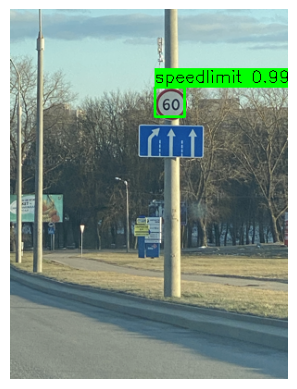

Time process:  6.148109436035156
images/road870.png


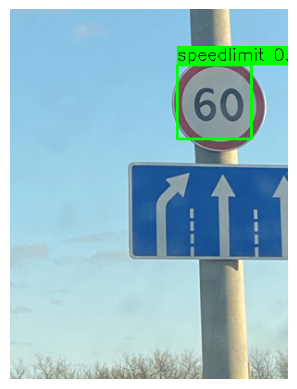

Time process:  3.687209129333496
images/road96.png


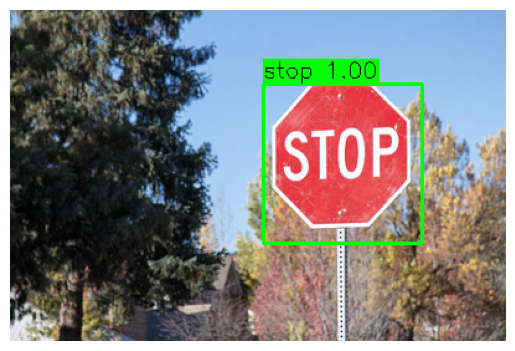

Time process:  3.2238197326660156
images/road868.png


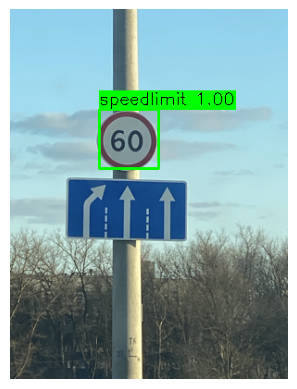

Time process:  5.174451112747192
images/road94.png


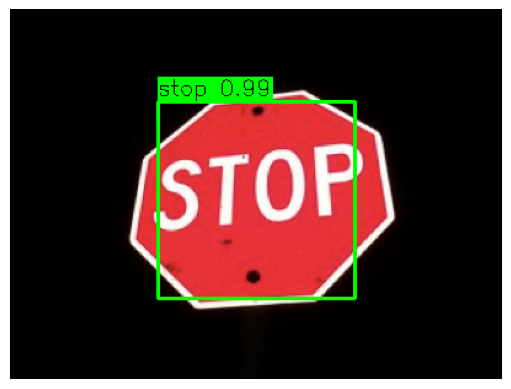

Time process:  4.762155294418335
images/road98.png


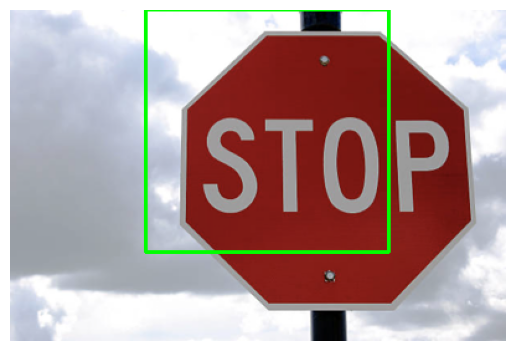

Time process:  5.611337661743164
images/road9.png


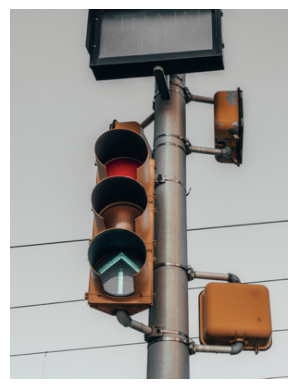

Time process:  4.749004364013672
images/road874.png


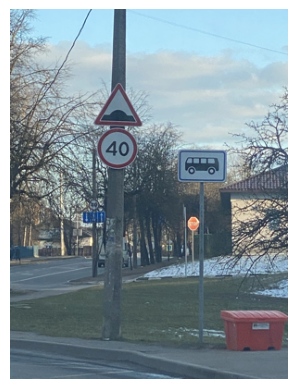

Time process:  3.7358062267303467
images/road873.png


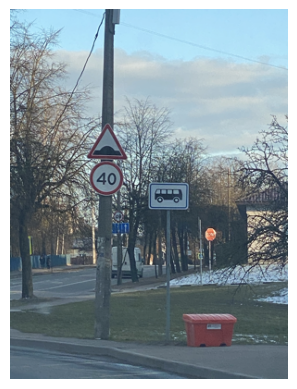

Time process:  3.7562687397003174
images/road866.png


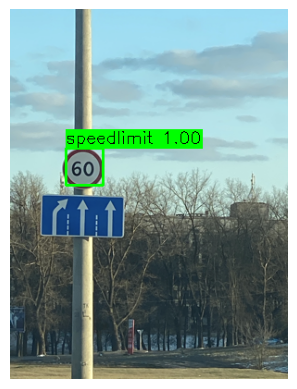

Time process:  5.499812841415405
images/road872.png


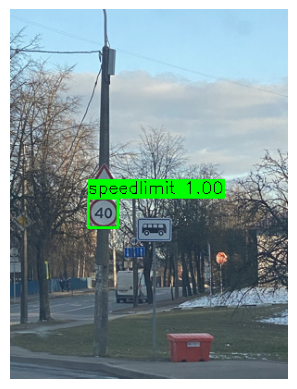

Time process:  5.11335301399231
images/road88.png


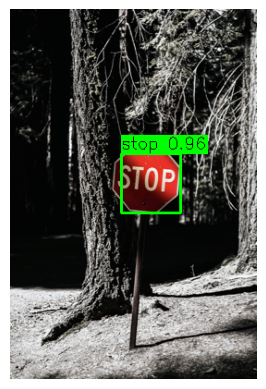

Time process:  3.2210917472839355
images/road93.png


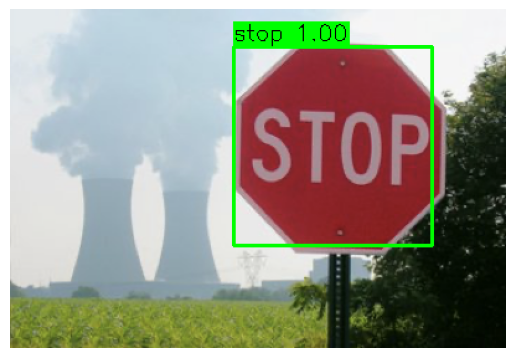

Time process:  3.310081958770752
images/road869.png


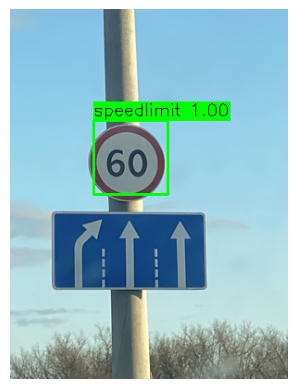

Time process:  5.412797212600708
images/road95.png


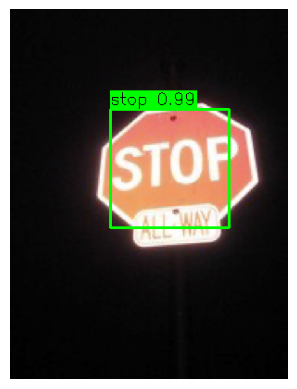

Time process:  3.7326745986938477
images/road89.png


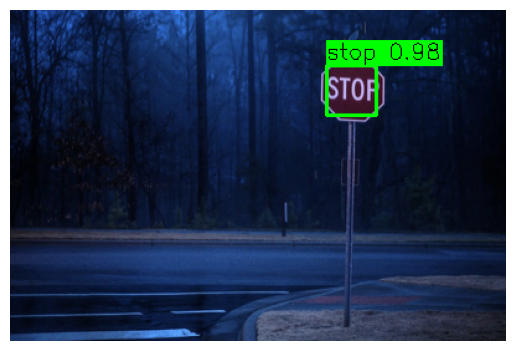

Time process:  3.302597999572754
images/road876.png


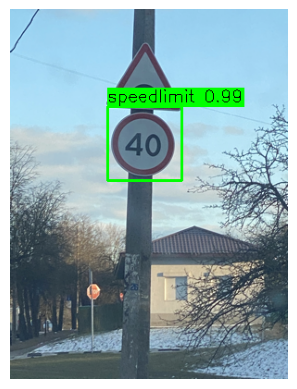

Time process:  4.45302677154541
images/road99.png


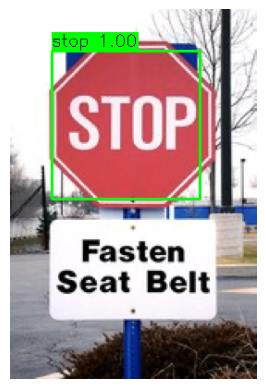

Time process:  4.1327149868011475
images/road867.png


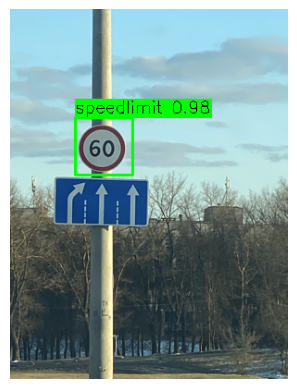

Time process:  3.758612632751465
images/road87.png


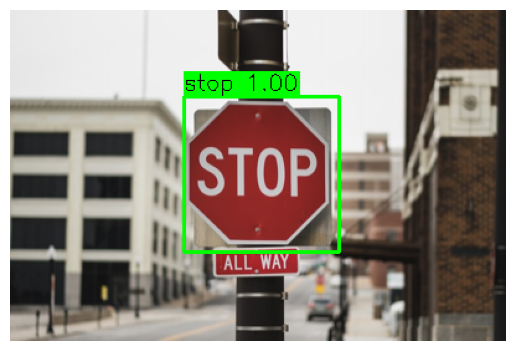

Time process:  3.239614725112915


In [ ]:
import time

img_dir = 'images'
img_filename_lst = os.listdir(img_dir)[-20:]
conf_threshold = 0.95
iou_threshold = 0.1
stride = 12
window_sizes = [
    (32, 32),
    (64, 64),
    (128, 128)
]

for img_filename in img_filename_lst:
    start_time = time.time()
    img_filepath = os.path.join(img_dir, img_filename)
    print(img_filepath)
    bboxes = []
    img = cv2.imread(img_filepath)
    pyramid_imgs = pyramid(img)

    for pyramid_img_info in pyramid_imgs:
        pyramid_img, scale_factor = pyramid_img_info
        window_lst = sliding_window(
            pyramid_img,
            window_sizes=window_sizes,
            stride=stride,
            scale_factor=scale_factor
        )
        for window in window_lst:
            xmin, ymin, xmax, ymax = window
            object_img = pyramid_img[ymin:ymax, xmin:xmax]
            preprocessed_img = preprocessing_img(object_img)
            normalized_img = scaler.transform([preprocessed_img])[0]
            decision = clf.predict_proba([normalized_img])[0]
            if np.all(decision < conf_threshold):
                continue
            else:
                predict_id = np.argmax(decision)
                conf_score = decision[predict_id]
                xmin = int(xmin / scale_factor)
                ymin = int(ymin / scale_factor)
                xmax = int(xmax / scale_factor)
                ymax = int(ymax / scale_factor)
                bboxes.append(
                    [xmin, ymin, xmax, ymax, predict_id, conf_score]
                )
    bboxes = nms(bboxes, iou_threshold)
    visualize_bbox(img, bboxes, label_encoder)

    print('Time process: ', time.time() - start_time)